In [ ]:
! pip install transformers datasets
! pip install evaluate
! pip install sentence-transformers

# Part A: Fine-tune a Pretrained Model

Language models are typically trained in two main stages:

1. **Pre-training on large unlabelled datasets**:

   Pre-training is extremely computationally expensive, and thus in practice we rarely perform it ourselves when applying a model to a new dataset. We can think of pre-training as the process where a model learns the general structure and rules of language. This foundational knowledge can then be transferred to a variety of downstream tasks.

2. **Fine-tuning on smaller labelled datasets**:

   Fine-tuning leverages the principles of transfer learning to adapt the knowledge encoded during pre-training to a specific task. Each task is supported by a targeted dataset. For example, some datasets are designed for classifying text into categories (text classification), others involve answering questions (question answering), and so on.

Some common natural language processing (NLP) tasks include:
- Text classification
- Question answering
- Natural language inference
- Fill-mask prediction
- Semantic similarity

For more information on these tasks and related models, you can refer to the NLP domain on Hugging Face: https://huggingface.co/models

In the first part of this lab exercise, we will apply the pre-training + fine-tuning paradigm to classify user reviews.


## Pipelines

Using the **text-classification pipeline**, we can run pretrained language models on classification-related NLP tasks.

One such task is **Natural Language Inference (NLI)**, where the goal is to classify the relationship between two sentences. For example, the model `roberta-large-mnli` predicts one of the three categories:

- **entailment** → The hypothesis logically follows from the premise.
- **neutral** → The hypothesis might be true, but it is not guaranteed by the premise.
- **contradiction** → The hypothesis is in conflict with the premise.

We provide two inputs:
- **Premise**: the original statement
- **Hypothesis**: the statement we want to verify against the premise

Example:

```python
from transformers import pipeline

classifier = pipeline("text-classification", model="roberta-large-mnli")
classifier("A soccer game with multiple males playing. Some men are playing a sport.")
# [{'label': 'ENTAILMENT', 'score': 0.98}]


## Yelp polarity

We download the [Yelp Polarity](https://huggingface.co/datasets/yelp_polarity) dataset, which contains customer reviews expressing sentiment about restaurants.

In this dataset, Yelp reviews are categorized based on the original star ratings:
- Reviews with 1 or 2 stars are considered **negative** (labeled as class `1`)
- Reviews with 3 or 4 stars are considered **positive** (labeled as class `2`)

These reviews are thus split into two sentiment categories.  
Our objective is to train a model that can accurately classify new, unseen reviews into the correct sentiment class.


In [ ]:
from datasets import load_dataset

# insert your code here

dataset = load_dataset("fancyzhx/yelp_polarity")



# Exploring the dataset

In [ ]:
print(dataset)
"""
returns a dictionary of dictionaries

"""

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 560000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 38000
    })
})


'\nreturns a dictionary of dictionaries\n\n'

In [ ]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]


**Understanding the data:**

In [ ]:
print(train_dataset.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['1', '2'], id=None)}


In [ ]:
print(dataset["train"].features["label"].names)

['1', '2']


In [ ]:
#Printing some examples
print(f"Example 1: { train_dataset['text'][0] }")
print(f"Label: {train_dataset['label'][0] }\n")

print(f"Example 1: { train_dataset['text'][1] }")
print(f"Label: {train_dataset['label'][1] }\n")



Example 1: Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars.
Label: 0

Example 1: Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very patient

In [ ]:
from datasets import Dataset


#We will create a subset of train and test sets with 500 samples, 250 for each label class

#filter the sets
#train
train_subset_class_0 = train_dataset.filter(lambda x: x['label'] == 0)
train_subset_class_1 = train_dataset.filter(lambda x: x['label'] == 1)
#test
test_subset_class_0 = test_dataset.filter(lambda x: x['label'] == 0)
test_subset_class_1 = test_dataset.filter(lambda x: x['label'] == 1)



# Take 250 samples from each class
train_subset_class_0 = train_subset_class_0.shuffle(seed=42).select(range(250))
train_subset_class_1 = train_subset_class_1.shuffle(seed=42).select(range(250))
test_subset_class_0 = test_subset_class_0.shuffle(seed=42).select(range(250))
test_subset_class_1 = test_subset_class_1.shuffle(seed=42).select(range(250))



#concatenate the subsets of each class
train_subset = Dataset.from_dict({
    'text': train_subset_class_0['text'] + train_subset_class_1['text'],
    'label': train_subset_class_0['label'] + train_subset_class_1['label']})

test_subset = Dataset.from_dict({
    'text': test_subset_class_0['text'] + test_subset_class_1['text'],
    'label': test_subset_class_0['label'] + test_subset_class_1['label']})


#shuffle to have the samples in mixed classes
train_subset = train_subset.shuffle(seed=42)
test_subset = test_subset.shuffle(seed=42)


# Έλεγξε το μέγεθος του νέου subset
print(f"Train subset size: {len(train_subset)}")
print(f"Train subset size: {len(test_subset)}")




In [ ]:
#renaming the sets
train_set = train_subset
test_set = test_subset

# Language Models

Before feeding text into a language model, it must first be preprocessed.

This preprocessing is handled by **Tokenizers**, which convert input tokens into vocabulary IDs based on the model’s pretrained vocabulary. In other words, they transform raw text into a numerical format that can be processed by Transformer models. The Hugging Face library provides easy-to-use, high-level tokenization tools, which we recommend using throughout this exercise.

Specifically, **we initialize tokenization using `AutoTokenizer`**. By calling the **`from_pretrained`** method, we load a tokenizer that matches the architecture of the model we intend to use, ensuring compatibility.

You can find more details about AutoTokenizer here:  
🔗 https://huggingface.co/docs/transformers/model_doc/auto

For example, when using the BERT model, tokenization and model initialization can be done as follows:

```python
from transformers import AutoTokenizer, BertModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

############### WE CHOSE MODEL DistilBERT #########################3


# AutoTokenizer automatically takes the tokenizer of the model (each model has different tokenizer)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

#we stack a classification layer to the model
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")

In [ ]:
#Example to see what tokenizer does
tokenizer("Hello, I'm a pizza lover!")

{'input_ids': [101, 7592, 1010, 1045, 1005, 1049, 1037, 10733, 7089, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

**As we can see, the sentence has less number of words than the number of tokens so the tokenizer do not just split each word to a token but maybe it splits between letters too.**

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True) #padding because the samples do not have same length

#map() applies the function to every sample of the data set
tokenized_train_set = train_set.map(tokenize_function, batched=True)
tokenized_test_set = test_set.map(tokenize_function, batched=True)


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
max_length = model.config.max_position_embeddings
print(max_length)

512


In [ ]:
tokenized_train_set

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 500
})

In [ ]:
#printing an example

print(f"\nTokenized example: {tokenized_train_set[0]['text']}")
print(f"input_ids: {tokenized_train_set[0]['label']}")
print(f"input_ids: {tokenized_train_set[0]['input_ids']}")
print(f"attention_mask: {tokenized_train_set[0]['attention_mask']}")


Tokenized example: I've had a few problems with them before, however every time ((the lead male groomer)) corrects it by apologizing and taking $10 off. They are always friendly an considerate with my dog. The only thing I don't like is waiting for my dog but I'm just impatient. \n\nTl:dr; \nThey are pretty good.
input_ids: 1
input_ids: [101, 1045, 1005, 2310, 2018, 1037, 2261, 3471, 2007, 2068, 2077, 1010, 2174, 2296, 2051, 1006, 1006, 1996, 2599, 3287, 18087, 2121, 1007, 1007, 6149, 2015, 2009, 2011, 9706, 12898, 28660, 1998, 2635, 1002, 2184, 2125, 1012, 2027, 2024, 2467, 5379, 2019, 5136, 3686, 2007, 2026, 3899, 1012, 1996, 2069, 2518, 1045, 2123, 1005, 1056, 2066, 2003, 3403, 2005, 2026, 3899, 2021, 1045, 1005, 1049, 2074, 17380, 1012, 1032, 1050, 1032, 23961, 2140, 1024, 2852, 1025, 1032, 23961, 14844, 2024, 3492, 2204, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Using the PyTorch `Trainer` for Fine-Tuning

The [`Trainer`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) class has been carefully optimized by the Hugging Face team to handle most of the “boilerplate” involved in training, saving you from writing a custom training loop.

We recommend adopting `Trainer` as an alternative to coding your own loop from scratch.  
Because `Trainer` does **not** evaluate model performance automatically during training, we provide a helper function that measures **accuracy** at the end of each epoch so you can monitor progress.


In [ ]:
import numpy as np
import evaluate
import torch
from tqdm import tqdm
from transformers import pipeline

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1) #axis=-1 to compute for each sample
    return metric.compute(predictions=predictions, references=labels)

## Hyperparameter Tuning with `TrainingArguments`

The [`TrainingArguments`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments) class defines all the key hyperparameters that you can experiment with during fine-tuning.

You are encouraged to experiment with different hyperparameters such as:
- `learning_rate`
- `batch_size`
- `weight_decay`
- `num_train_epochs`
- `optimizer` and `lr_scheduler_type`

Since the model is already pretrained, it is recommended to perform fine-tuning for a small number of epochs (typically 2–4).



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import TrainingArguments, Trainer
from torch.optim import AdamW
from transformers import get_scheduler

# Hyperparameters

* **Learning Rate:** This hyperparameter controls how much the weights are updated each time gradient descent is calculated. A **high learning rate** means abrupt changes to the weights, which often leads to getting stuck in local minima. A **low learning rate** results in slow training.

* **Optimizer:** This is the algorithm used to adjust the weights. It uses the gradients computed from the loss function to update the weights in a way that minimizes the loss.

Examples: adam, gradient descent.

* **Scheduler:** Responsible for adjusting the learning rate during training. Instead of keeping the learning rate constant throughout, the scheduler allows it to change as training progresses.

Examples: linear, cosine.

* **Batch size:** The logic behind mini-batches is that we process data in “groups” instead of one-by-one. This improves performance and training time, especially when using a GPU that supports parallel computation. Additionally, weights—updated per mini-batch—are now adjusted based on a group of data points rather than a single one at a time. This helps the model learn from more data before updating weights prematurely and computing gradients for each individual sample.

Based on this:
- Smaller mini-batches lead to noisier weight updates, since they are based on fewer data points. They may help the model escape local minima.
- Larger mini-batches result in more stable gradients, but may make it easier to get stuck in local minima.

* **Weight decay (regularization):** Weight decay adds a penalty to the loss function to discourage the model from assigning excessively large values to its weights. It attempts to keep weights small to avoid overfitting.

Smaller weights → simpler models.  
Simpler models → better generalization.  
This reduces overfitting.


# Hyperparameters

* **learning rate = 5e-5**

* **epochs = 5**

* **batch size = 16**

* **optimizer = Adam**

* **scheduler = linear**

* **weigth decay = 0.01**

In [ ]:

learning_rate = 5e-5
num_train_epochs = 5
batch_size = 16
weight_decay = 0.01 #penalty to prevent overfitting



#optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)


#scheduler
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_set) * num_train_epochs,  
)




args = TrainingArguments(
                         output_dir = "/content/drive/MyDrive/Deep_Learning_Lab2/trained_model1",
                         evaluation_strategy="epoch",
                         per_device_train_batch_size=batch_size,
                         per_device_eval_batch_size=64,
                         num_train_epochs=num_train_epochs,
                         weight_decay=weight_decay,
                         logging_steps=10,
                         )



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train_set,
    eval_dataset=tokenized_test_set,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler)
)



Στη συνέχεια, ρυθμίστε (fine-tune) το μοντέλο σας καλώντας το [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train):

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


trained_model=trainer.train()

# Experimenting with epochs

**We increase epochs to 10:**

In [ ]:
# insert your code here

learning_rate = 5e-5
num_train_epochs = 10
batch_size = 16
weight_decay = 0.01 #penalty to prevent overfitting



#optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)


#scheduler
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_set) * num_train_epochs,  
)




args = TrainingArguments(
                         output_dir = "/content/drive/MyDrive/Deep_Learning_Lab2/trained_model2",
                         evaluation_strategy="epoch",
                         per_device_train_batch_size=batch_size,
                         per_device_eval_batch_size=64,
                         num_train_epochs=num_train_epochs,
                         weight_decay=weight_decay,
                         logging_steps=10,
                         )



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train_set,
    eval_dataset=tokenized_test_set,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler)
)



In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


trained_model=trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.050500,0.589148,0.922000
2,0.046400,0.648174,0.916000
3,0.036800,0.856359,0.886000
4,0.001700,0.636735,0.908000
5,0.069900,0.830303,0.900000
6,0.000600,0.562232,0.904000
7,0.010300,1.427112,0.832000
8,0.106900,0.699152,0.898000
9,0.000100,0.648310,0.906000
10,0.000000,0.626076,0.918000


**We observe a decrease in accuracy when increasing the number of epochs to 10 (overfitting).**


**We increase epochs to 15:**

In [ ]:
# insert your code here

learning_rate = 5e-5
num_train_epochs = 15
batch_size = 16
weight_decay = 0.01 #penalty to prevent overfitting



#optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)


#scheduler
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_set) * num_train_epochs,  # Συνολικός αριθμός βημάτων εκπαίδευσης
)




args = TrainingArguments(output_dir = "/content/drive/MyDrive/Deep_Learning_Lab2/trained_model3",
                         evaluation_strategy="epoch",
                         per_device_train_batch_size=batch_size,
                         per_device_eval_batch_size=64,
                         num_train_epochs=num_train_epochs,
                         weight_decay=weight_decay,
                         logging_steps=10,
                         )



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train_set,
    eval_dataset=tokenized_test_set,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler)
)



In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


trained_model=trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.000000,1.744906,0.870000
2,0.006700,1.078307,0.872000
3,0.000400,0.835268,0.916000
4,0.000000,1.057811,0.886000
5,0.000000,0.576386,0.928000
6,0.000000,0.601138,0.928000
7,0.000000,0.616973,0.928000
8,0.000000,0.630900,0.930000
9,0.000000,0.642544,0.930000
10,0.000000,0.652715,0.930000


# Learining rate


**We will take the number of epochs = 10, where we observed the worst-performing model, and experiment by reducing the learning rate. We estimate that the poor accuracy at 10 epochs may improve by lowering the learning rate.**


In [ ]:
# insert your code here

learning_rate = 5e-6
num_train_epochs = 10
batch_size = 16
weight_decay = 0.01 #penalty to prevent overfitting



#optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)


#scheduler
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_set) * num_train_epochs,  
)




args = TrainingArguments(
                         output_dir = "/content/drive/MyDrive/Deep_Learning_Lab2/trained_model2",
                         evaluation_strategy="epoch",
                         per_device_train_batch_size=batch_size,
                         per_device_eval_batch_size=64,
                         num_train_epochs=num_train_epochs,
                         weight_decay=weight_decay,
                         logging_steps=10,
                         )



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train_set,
    eval_dataset=tokenized_test_set,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler)
)



In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


trained_model=trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.121400,0.210020,0.928000
2,0.055700,0.208677,0.932000
3,0.040500,0.217059,0.934000
4,0.045100,0.238479,0.934000
5,0.039400,0.251433,0.932000
6,0.037300,0.262909,0.934000
7,0.007100,0.270510,0.934000
8,0.005900,0.278470,0.936000
9,0.005300,0.280622,0.940000
10,0.034000,0.279264,0.938000


A slight improvement is observed.


**Even smaller lr=4e-6 :**

In [ ]:
# insert your code here

learning_rate = 4e-6
num_train_epochs = 10
batch_size = 16
weight_decay = 0.01 #penalty to prevent overfitting



#optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)


#scheduler
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_set) * num_train_epochs,  # Συνολικός αριθμός βημάτων εκπαίδευσης
)




args = TrainingArguments(
                         output_dir = "/content/drive/MyDrive/Deep_Learning_Lab2/trained_model2",
                         evaluation_strategy="epoch",
                         per_device_train_batch_size=batch_size,
                         per_device_eval_batch_size=64,
                         num_train_epochs=num_train_epochs,
                         weight_decay=weight_decay,
                         logging_steps=10,
                         )



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train_set,
    eval_dataset=tokenized_test_set,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler)
)



In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


trained_model=trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.003200,0.331787,0.922000
2,0.002100,0.302170,0.938000
3,0.001900,0.313252,0.938000
4,0.007500,0.337621,0.930000
5,0.001200,0.324686,0.940000
6,0.000900,0.327553,0.940000
7,0.000800,0.332938,0.942000
8,0.000700,0.342320,0.940000
9,0.000600,0.350462,0.942000
10,0.000500,0.357981,0.938000


**lr=3e-6 :**

In [ ]:
# insert your code here

learning_rate = 3e-6
num_train_epochs = 10
batch_size = 16
weight_decay = 0.01 #penalty to prevent overfitting



#optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)


#scheduler
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_set) * num_train_epochs,  # Συνολικός αριθμός βημάτων εκπαίδευσης
)




args = TrainingArguments(
                         output_dir = "/content/drive/MyDrive/Deep_Learning_Lab2/trained_model2",
                         evaluation_strategy="epoch",
                         per_device_train_batch_size=batch_size,
                         per_device_eval_batch_size=64,
                         num_train_epochs=num_train_epochs,
                         weight_decay=weight_decay,
                         logging_steps=10,
                         )



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train_set,
    eval_dataset=tokenized_test_set,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler)
)



In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


trained_model=trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.000300,0.401980,0.934000
2,0.000200,0.413587,0.938000
3,0.000200,0.445529,0.930000
4,0.000100,0.446599,0.940000
5,0.000100,0.472032,0.938000
6,0.000100,0.473069,0.940000
7,0.000100,0.488725,0.938000
8,0.000100,0.484996,0.940000
9,0.000100,0.498588,0.940000
10,0.000000,0.501824,0.940000


Even more improvement.

**lr=3e-7 :**

In [ ]:
# insert your code here

learning_rate = 3e-7
num_train_epochs = 10
batch_size = 16
weight_decay = 0.01 #penalty to prevent overfitting



#optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)


#scheduler
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_set) * num_train_epochs,  # Συνολικός αριθμός βημάτων εκπαίδευσης
)




args = TrainingArguments(
                         output_dir = "/content/drive/MyDrive/Deep_Learning_Lab2/trained_model2",
                         evaluation_strategy="epoch",
                         per_device_train_batch_size=batch_size,
                         per_device_eval_batch_size=64,
                         num_train_epochs=num_train_epochs,
                         weight_decay=weight_decay,
                         logging_steps=10,
                         )



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train_set,
    eval_dataset=tokenized_test_set,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler)
)



In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


trained_model=trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.000000,0.506462,0.938000
2,0.000000,0.508878,0.938000
3,0.000000,0.515185,0.936000
4,0.000000,0.517304,0.936000
5,0.000000,0.516780,0.938000
6,0.000000,0.526096,0.936000
7,0.000000,0.520658,0.936000
8,0.000000,0.522039,0.936000
9,0.000000,0.519051,0.940000
10,0.000000,0.525058,0.936000


With further reduction of the learning rate, we observe a drop in accuracy again.


**lr=3e-9 :**

In [ ]:
# insert your code here

learning_rate = 3e-9
num_train_epochs = 10
batch_size = 16
weight_decay = 0.01 #penalty to prevent overfitting



#optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)


#scheduler
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_set) * num_train_epochs,  # Συνολικός αριθμός βημάτων εκπαίδευσης
)




args = TrainingArguments(
                         output_dir = "/content/drive/MyDrive/Deep_Learning_Lab2/trained_model2",
                         evaluation_strategy="epoch",
                         per_device_train_batch_size=batch_size,
                         per_device_eval_batch_size=64,
                         num_train_epochs=num_train_epochs,
                         weight_decay=weight_decay,
                         logging_steps=10,
                         )



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train_set,
    eval_dataset=tokenized_test_set,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler)
)



In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


trained_model=trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.000000,0.527859,0.936000
2,0.000000,0.527880,0.936000
3,0.000000,0.527924,0.936000
4,0.000000,0.528008,0.936000
5,0.000000,0.528046,0.936000
6,0.000000,0.528130,0.936000
7,0.000000,0.528148,0.936000
8,0.000000,0.528193,0.936000
9,0.000000,0.528141,0.936000
10,0.000000,0.528143,0.936000


# Weight decay.

Keeping the best model (**accuracy = 94%**) from the above:

* **learning rate = 3e-6**
* **epochs = 10**
* **batch size = 16**
* **optimizer = Adam**
* **scheduler = linear**
* **weight decay = 0.01**

we will increase the weight decay (weight penalty).


We increase weight decay to 0.03:

In [ ]:
# insert your code here

learning_rate = 3e-6
num_train_epochs = 10
batch_size = 16
weight_decay = 0.03 #penalty to prevent overfitting



#optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)


#scheduler
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_set) * num_train_epochs,  # Συνολικός αριθμός βημάτων εκπαίδευσης
)




args = TrainingArguments(
                         output_dir = "/content/drive/MyDrive/Deep_Learning_Lab2/trained_model2",
                         evaluation_strategy="epoch",
                         per_device_train_batch_size=batch_size,
                         per_device_eval_batch_size=64,
                         num_train_epochs=num_train_epochs,
                         weight_decay=weight_decay,
                         logging_steps=10,
                         )



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train_set,
    eval_dataset=tokenized_test_set,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler)
)



In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


trained_model=trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.000000,0.799321,0.934000
2,0.000000,0.804998,0.934000
3,0.000000,0.812151,0.934000
4,0.000000,0.819633,0.936000
5,0.000000,0.823571,0.934000
6,0.000000,0.832220,0.936000
7,0.000000,0.833779,0.934000
8,0.000000,0.839476,0.934000
9,0.000000,0.839813,0.930000
10,0.000000,0.843061,0.928000


We increase weight decay to 0.05:

In [ ]:
# insert your code here

learning_rate = 3e-6
num_train_epochs = 10
batch_size = 16
weight_decay = 0.05 #penalty to prevent overfitting



#optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)


#scheduler
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_set) * num_train_epochs,  # Συνολικός αριθμός βημάτων εκπαίδευσης
)




args = TrainingArguments(
                         output_dir = "/content/drive/MyDrive/Deep_Learning_Lab2/trained_model2",
                         evaluation_strategy="epoch",
                         per_device_train_batch_size=batch_size,
                         per_device_eval_batch_size=64,
                         num_train_epochs=num_train_epochs,
                         weight_decay=weight_decay,
                         logging_steps=10,
                         )



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train_set,
    eval_dataset=tokenized_test_set,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler)
)



In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


trained_model=trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.000000,0.723913,0.936000
2,0.000000,0.734784,0.936000
3,0.000000,0.750448,0.936000
4,0.000000,0.758035,0.936000
5,0.000000,0.760790,0.934000
6,0.000000,0.777906,0.936000
7,0.000000,0.774828,0.934000
8,0.000000,0.782485,0.936000
9,0.000000,0.782371,0.928000
10,0.000000,0.788170,0.928000


ΑυWe increase weight decay to 0.5:

In [ ]:
# insert your code here

learning_rate = 3e-6
num_train_epochs = 10
batch_size = 16
weight_decay = 0.5 #penalty to prevent overfitting



#optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)


#scheduler
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_set) * num_train_epochs,  # Συνολικός αριθμός βημάτων εκπαίδευσης
)




args = TrainingArguments(
                         output_dir = "/content/drive/MyDrive/Deep_Learning_Lab2/trained_model2",
                         evaluation_strategy="epoch",
                         per_device_train_batch_size=batch_size,
                         per_device_eval_batch_size=64,
                         num_train_epochs=num_train_epochs,
                         weight_decay=weight_decay,
                         logging_steps=10,
                         )



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train_set,
    eval_dataset=tokenized_test_set,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler)
)



In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


trained_model=trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.000000,0.905340,0.932000
2,0.000000,0.907104,0.932000
3,0.000000,0.908925,0.932000
4,0.000000,0.910750,0.932000
5,0.000000,0.912560,0.932000
6,0.000000,0.914764,0.934000
7,0.000000,0.916265,0.932000
8,0.000000,0.917584,0.932000
9,0.000000,0.918149,0.932000
10,0.000000,0.918965,0.932000


It seems that the conservative penalty of 0.01 is the most effective.


# **Batch size.**

Keeping the best model (**accuracy = 94%**) from the above:

* **learning rate = 3e-6**
* **epochs = 10**
* **batch size = 16**
* **optimizer = Adam**
* **scheduler = linear**
* **weight decay = 0.01**

we will increase the batch size and observe the results.


We increase batch size to 32:



In [ ]:
# insert your code here

learning_rate = 3e-6
num_train_epochs = 10
batch_size = 32
weight_decay = 0.01 #penalty to prevent overfitting



#optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)


#scheduler
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_set) * num_train_epochs,  # Συνολικός αριθμός βημάτων εκπαίδευσης
)




args = TrainingArguments(
                         output_dir = "/content/drive/MyDrive/Deep_Learning_Lab2/trained_model2",
                         evaluation_strategy="epoch",
                         per_device_train_batch_size=batch_size,
                         per_device_eval_batch_size=64,
                         num_train_epochs=num_train_epochs,
                         weight_decay=weight_decay,
                         logging_steps=10,
                         )



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train_set,
    eval_dataset=tokenized_test_set,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler)
)



In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


trained_model=trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.000000,0.919081,0.932000
2,0.000000,0.919012,0.930000
3,0.000000,0.919703,0.930000
4,0.000000,0.920446,0.930000
5,0.000000,0.921244,0.930000
6,0.000000,0.922186,0.930000
7,0.000000,0.922917,0.930000
8,0.000000,0.923534,0.930000
9,0.000000,0.924150,0.930000
10,0.000000,0.924753,0.930000


We increase batch size to 64:


In [ ]:
# insert your code here

learning_rate = 3e-6
num_train_epochs = 10
batch_size = 64
weight_decay = 0.01 #penalty to prevent overfitting



#optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)


#scheduler
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_set) * num_train_epochs,  # Συνολικός αριθμός βημάτων εκπαίδευσης
)




args = TrainingArguments(
                         output_dir = "/content/drive/MyDrive/Deep_Learning_Lab2/trained_model2",
                         evaluation_strategy="epoch",
                         per_device_train_batch_size=batch_size,
                         per_device_eval_batch_size=64,
                         num_train_epochs=num_train_epochs,
                         weight_decay=weight_decay,
                         logging_steps=10,
                         )



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train_set,
    eval_dataset=tokenized_test_set,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler)
)



In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


trained_model=trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.924768,0.930000
2,0.000000,0.925046,0.930000
3,0.000000,0.925286,0.930000
4,0.000000,0.925560,0.930000
5,0.000000,0.925943,0.930000
6,0.000000,0.926388,0.930000
7,0.000000,0.926798,0.930000
8,0.000000,0.927274,0.930000
9,0.000000,0.927690,0.930000
10,0.000000,0.928045,0.930000


We increase batch size to 80:


In [ ]:
# insert your code here

learning_rate = 3e-6
num_train_epochs = 10
batch_size = 80
weight_decay = 0.01 #penalty to prevent overfitting



#optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)


#scheduler
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_set) * num_train_epochs,  # Συνολικός αριθμός βημάτων εκπαίδευσης
)




args = TrainingArguments(

                         evaluation_strategy="epoch",
                         per_device_train_batch_size=batch_size,
                         per_device_eval_batch_size=4,
                         num_train_epochs=num_train_epochs,
                         weight_decay=weight_decay,
                         logging_steps=10,
                         )



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train_set,
    eval_dataset=tokenized_test_set,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler)
)



In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


trained_model=trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.928447,0.930000
2,0.000000,0.928662,0.930000
3,0.000000,0.928935,0.930000
4,0.000000,0.929271,0.930000
5,0.000000,0.929593,0.930000
6,0.000000,0.929977,0.930000
7,0.000000,0.930273,0.930000
8,0.000000,0.930571,0.930000
9,0.000000,0.930843,0.930000
10,0.000000,0.931112,0.930000


We reduce batch size to 4:

In [ ]:
# insert your code here

learning_rate = 3e-6
num_train_epochs = 10
batch_size = 4
weight_decay = 0.01 #penalty to prevent overfitting



#optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)


#scheduler
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_set) * num_train_epochs,  # Συνολικός αριθμός βημάτων εκπαίδευσης
)




args = TrainingArguments(

                         evaluation_strategy="epoch",
                         per_device_train_batch_size=batch_size,
                         per_device_eval_batch_size=4,
                         num_train_epochs=num_train_epochs,
                         weight_decay=weight_decay,
                         logging_steps=10,
                         )



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train_set,
    eval_dataset=tokenized_test_set,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler)
)



In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"



trained_model=trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.000000,0.937752,0.932000
2,0.000000,0.940661,0.930000
3,0.000000,0.942769,0.930000
4,0.000000,0.946202,0.930000
5,0.000000,0.950759,0.930000
6,0.000000,0.953640,0.930000
7,0.000000,0.956470,0.932000
8,0.000000,0.959343,0.932000
9,0.000000,0.960768,0.930000
10,0.000000,0.963372,0.932000


# Hyperparameters

* **Learning Rate:** This hyperparameter controls how the model's weights are updated during each gradient descent step. A **high learning rate** causes large updates to the weights and can often result in getting stuck in local minima. A **low learning rate** leads to slower training.

* **Batch Size:** The idea behind mini-batches is to feed data in groups instead of one sample at a time. This leads to better performance and faster training, especially when using GPUs that support parallel processing. Additionally, weights—updated per mini-batch—are now adjusted based on a group of samples, rather than individually. This allows the model to learn from more data before updating weights prematurely.

  Based on this:
  - Smaller mini-batches lead to noisier weight updates, since they are based on fewer data points. They may help the model escape local minima.
  - Larger mini-batches produce more stable gradients, but can increase the risk of getting stuck in local minima.

* **Weight Decay (regularization):** Weight decay adds a penalty to the loss function to discourage the model from assigning large values to its weights. In essence, it tries to keep the weights as small as possible in order to prevent overfitting.

  → Smaller weights mean simpler models.  
  → Simpler models generalize better.  
  → This reduces overfitting.

* **Optimizer:** This is the algorithm used to update the model's weights. It uses the gradients computed from the loss function to adjust the weights in a way that minimizes the loss.

  Examples: adam, gradient descent.

* **Scheduler:** Responsible for adjusting the learning rate during training. Instead of keeping the learning rate constant, the scheduler allows it to change over the course of training.

  Examples: linear, cosine.


# Results

We begin our experimentation by varying the number of training epochs. For each experiment, all other hyperparameters are held constant at the values mentioned earlier:

| Epochs | Accuracy |
|--------|----------|
| 5      | 0.9300   |
| 10     | 0.9180   |
| 15     | 0.9300   |

At 10 epochs, we observe that the model begins to “unlearn” and overfits to the training data, resulting in a slight drop in performance.

Next, for the case of 10 epochs, we investigate whether reducing the learning rate can improve the model’s performance:

| Learning Rate | Accuracy (Epochs = 10) |
|---------------|------------------------|
| 5e-5          | 0.9180                 |
| 5e-6          | 0.9380                 |
| 4e-6          | 0.9380                 |
| 3e-6          | 0.9400                 |
| 3e-7          | 0.9360                 |
| 3e-9          | 0.9360                 |

We observe that reducing the learning rate consistently improves the model's accuracy, reaching up to **94%**, which is the best result so far.

We then continue experimenting with the weight decay parameter, using the best-performing model so far:

| Weight Decay | Accuracy (Epochs = 10) |
|--------------|------------------------|
| 0.01         | 0.9400                 |
| 0.03         | 0.9280                 |
| 0.05         | 0.9280                 |
| 0.5          | 0.9320                 |

It is clear that increasing the weight decay does not help improve model performance.

Finally, we test different batch sizes, again using the 10-epoch model with 94% accuracy. However, we consistently obtain slightly lower accuracy:

| Batch Size | Accuracy (Epochs = 10) |
|------------|------------------------|
| 16         | 0.9400                 |
| 32         | 0.9300                 |
| 64         | 0.9300                 |
| 80         | 0.9300                 |
| 4          | 0.9320                 |


# Part B: Using Fine-Tuned Models on New Tasks

In this part of the assignment, you do not need to perform any training on language models. Instead, we will leverage the capabilities of transfer learning to tackle more complex language tasks by converting them into classical NLP tasks such as text classification, natural language inference, question answering, and others.

For example, fine-tuned models for [text classification](https://huggingface.co/tasks/text-classification) can be used for tasks like:

- Are two sentences paraphrases of each other? → [Paraphrase / No Paraphrase]
- Does sentence X entail sentence Y? → [Entailment / Neutral / Contradiction]
- Is the given sentence grammatically correct? → [Acceptable / Unacceptable]


## B1. Piqa Dataset

The [Piqa dataset](https://huggingface.co/datasets/piqa) contains sentences designed to test the extent to which language models possess commonsense knowledge. Specifically, it consists of prompts followed by possible endings, which require real-world reasoning to be completed correctly.

For example, given the prompt:

> "When boiling butter, when it's ready, you can"

the model must choose between two candidate endings:
- "Pour it onto a plate"
- "Pour it into a jar"

A human can infer that the second option is more appropriate, since melted butter is a liquid, and a jar is a more suitable container than a plate.



In [ ]:
! pip install transformers datasets
#! pip install evaluate
#! pip install sentence-transformers

In [ ]:
# # insert your code here (load dataset)
from datasets import load_dataset

dataset = load_dataset("ybisk/piqa")



# Exploring the dataset

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['goal', 'sol1', 'sol2', 'label'],
        num_rows: 16113
    })
    test: Dataset({
        features: ['goal', 'sol1', 'sol2', 'label'],
        num_rows: 3084
    })
    validation: Dataset({
        features: ['goal', 'sol1', 'sol2', 'label'],
        num_rows: 1838
    })
})

In [ ]:
#keeping 100 samples from each set

#train
train_dataset = dataset['train']
train_subset = train_dataset.shuffle(seed=42).select(range(100))

#test
test_dataset = dataset['test']
test_subset = test_dataset.shuffle(seed=42).select(range(100))

#validation
validation_dataset = dataset['validation']
validation_subset = validation_dataset.shuffle(seed=42).select(range(100))

In [ ]:
#Understanding the data
print("Example 1:")
print(f"goal: {train_subset['goal'][0]}")
print(f"sol1: {train_subset['sol1'][0]}")
print(f"sol2: {train_subset['sol2'][0]}")
print(f"label: {train_subset['label'][0]}")

print("\nExample 2:")
print(f"goal: {train_subset['goal'][1]}")
print(f"sol1: {train_subset['sol1'][1]}")
print(f"sol2: {train_subset['sol2'][1]}")
print(f"label: {train_subset['label'][1]}")


Example 1:
goal: Do cardio exercise without running.
sol1: Use a jump rope for 15 minutes.
sol2: Run around a chair for 15 minutes.
label: 0

Example 2:
goal: To add a promo code to your Uber order
sol1: Open the Uber app.  Tap the History button.  Tap Payment.  Tap Add Promo/Gift Code.  Type in your PROMO CODE.  Tap ADD.
sol2: Open the Uber app.  Tap the menu button.  Tap Payment.  Tap Add Promo/Gift Code.  Type in your PROMO CODE.  Tap ADD.
label: 1


We can treat the above scenario as a multiple-choice problem, where there are two possible alternatives for completing the sentence. Therefore, by utilizing appropriate language models, we can resolve which of the two endings best completes the given prompt.

You are required to record the **prediction accuracy** for selecting the correct ending for each sentence using language models.  
For comparison purposes, use **at least 5 suitable models**.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# AutoTokenizer automatically takes the tokenizer of the model (each model has different tokenizer)
tokenizer1 = AutoTokenizer.from_pretrained("distilbert-base-uncased")  #binary classification
tokenizer2 = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
tokenizer3 = AutoTokenizer.from_pretrained("textattack/roberta-base-CoLA")
tokenizer4 = AutoTokenizer.from_pretrained("facebook/bart-large-mnli") # 3 ways classifier (entailment, neutral, contradaction)
tokenizer5 = AutoTokenizer.from_pretrained("roberta-large-mnli") # 3 ways classifier


# AutoModelForSequenceClassification για να φορτώσουμε τα μοντέλα
model1 = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")
model2 = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-base")
model3 = AutoModelForSequenceClassification.from_pretrained("textattack/roberta-base-CoLA")
model4 = AutoModelForSequenceClassification.from_pretrained("facebook/bart-large-mnli")
model5 = AutoModelForSequenceClassification.from_pretrained("roberta-large-mnli")


In [ ]:
def tokenize_function(example, tokenizer):
    input1 = tokenizer(example["goal"], example["sol1"],
                       padding="max_length", truncation=True, max_length=128, return_tensors="pt")
      #we gave the tokenizer two sentences


    input2 = tokenizer(example["goal"], example["sol2"],
                       padding="max_length", truncation=True, max_length=128, return_tensors="pt")

    return input1, input2




In [ ]:
#example for tokenizer
input1, input2 = tokenize_function(train_subset[0], tokenizer1)
print(input1)
print(f"\n {input2}")

{'input_ids': tensor([[ 101, 2079, 4003, 3695, 6912, 2302, 2770, 1012,  102, 2224, 1037, 5376,
         8164, 2005, 2321, 2781, 1012,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0,

In [ ]:
print(len(input1['input_ids'][0]))
print(len(input1['attention_mask'][0]))

#so attention mask sets the indexes that are not zero padding!!

128
128


# Predicting

In [ ]:
#Function to get logits and predict for binary classification models

"""
Παίρνουμε ένα goal, sol1, sol2.

Φτιάχνουμε δύο inputs: goal + sol1, goal + sol2.

Τα κάνουμε tokenize.

Τα περνάμε στο μοντέλο ξεχωριστά.

Παίρνουμε τα logits για κάθε input.

Επιλέγουμε εκείνο που δίνει υψηλότερη πιθανότητα.

"""

def predict_binary(model, tokenizer, sample):

  input1, input2 = tokenize_function(sample, tokenizer)

  with torch.no_grad():  #make sure we dont have back propagation
        output1 = model(**input1)  #unpuck the dictionary keys (ids and mask)
        output2 = model(**input2)  #and give their values to the model


  #logits
  logits1 = output1.logits
  logits2 = output2.logits

  #make logits propabilities
  probs1 = F.softmax(logits1, dim=-1)  # convert logits to probabilities
  probs2 = F.softmax(logits2, dim=-1)

  """
  example:
  probs1 = tensor([[0.4812, 0.5188]])
  probs2 = tensor([[0.4765, 0.5235]])
  which means that sol1 chances to be correct are 0.51 (class1=correct while class0=wrong)
  and sol2 chances to be correct are 0.52 (class1=correct while class0=wrong)

  """

  if probs1[0][1] > probs2[0][1]:
    prediction = 0 #label 0 means sol1
  else:
    prediction = 1

  return prediction, probs1, probs2



In [ ]:
#example: binary classification models
print("Example 1:")
print(f"goal: {train_subset['goal'][0]}")
print(f"sol1: {train_subset['sol1'][0]}")
print(f"sol2: {train_subset['sol2'][0]}")
print(f"label: {train_subset['label'][0]}")

prediction, probs1, probs2 = predict_binary(model1, tokenizer1, train_subset[0])
print(f"Model 1 prediction: {prediction}, probs1: {probs1}, probs2: {probs2}")

prediction, probs1, probs2 = predict_binary(model2, tokenizer2, train_subset[0])
print(f"Model 2 prediction: {prediction}, probs1: {probs1}, probs2: {probs2}")

prediction, probs1, probs2 = predict_binary(model3, tokenizer3, train_subset[0])
print(f"Model 3 prediction: {prediction}, probs1: {probs1}, probs2: {probs2}")



Example 1:
goal: Do cardio exercise without running.
sol1: Use a jump rope for 15 minutes.
sol2: Run around a chair for 15 minutes.
label: 0
Model 1 prediction: 0, probs1: tensor([[0.5196, 0.4804]]), probs2: tensor([[0.5230, 0.4770]])
Model 2 prediction: 0, probs1: tensor([[0.4230, 0.5770]]), probs2: tensor([[0.4240, 0.5760]])
Model 3 prediction: 0, probs1: tensor([[0.0239, 0.9761]]), probs2: tensor([[0.0243, 0.9757]])


In [ ]:
print(model4.config.id2label)
print(model5.config.id2label)

{0: 'contradiction', 1: 'neutral', 2: 'entailment'}
{0: 'CONTRADICTION', 1: 'NEUTRAL', 2: 'ENTAILMENT'}


In [ ]:

#Function to get logits and predict for binary classification models
def predict_three(model, tokenizer, sample):

  input1, input2 = tokenize_function(sample, tokenizer)

  with torch.no_grad():  #make sure we dont have back propagation
        output1 = model(**input1)  #unpuck the dictionary keys (ids and mask)
        output2 = model(**input2)  #and give their values to the model


  #logits
  logits1 = output1.logits
  logits2 = output2.logits

  #make logits propabilities
  probs1 = F.softmax(logits1, dim=-1)  # convert logits to probabilities
  probs2 = F.softmax(logits2, dim=-1)

  """
  example:
  probs1 = tensor([[0.4812, 0.5188, 0.693]])
  probs2 = tensor([[0.4765, 0.5235, 0.687]])
  which means that sol1 chances to be entailment are 0.693 (class3=entailemnt)
  and sol2 chances to be correct are 0.687 (class3=entailemnt)

  """

  if probs1[0][2] > probs2[0][2]:
    prediction = 0 #label 0 means sol1
  else:
    prediction = 1

  return prediction, probs1, probs2




In [ ]:
#example: 3 ways classification models
print("Example 1:")
print(f"goal: {train_subset['goal'][0]}")
print(f"sol1: {train_subset['sol1'][0]}")
print(f"sol2: {train_subset['sol2'][0]}")
print(f"label: {train_subset['label'][0]}")

prediction, probs1, probs2 = predict_three(model4, tokenizer4, train_subset[0])
print(f"Model 4 prediction: {prediction}, probs1: {probs1}, probs2: {probs2}")

prediction, probs1, probs2 = predict_three(model5, tokenizer5, train_subset[0])
print(f"Model 5 prediction: {prediction}, probs1: {probs1}, probs2: {probs2}")

Example 1:
goal: Do cardio exercise without running.
sol1: Use a jump rope for 15 minutes.
sol2: Run around a chair for 15 minutes.
label: 0
Model 4 prediction: 1, probs1: tensor([[3.0030e-04, 9.9956e-01, 1.4317e-04]]), probs2: tensor([[8.5895e-04, 9.9892e-01, 2.2109e-04]])
Model 5 prediction: 1, probs1: tensor([[0.6102, 0.3868, 0.0031]]), probs2: tensor([[0.7979, 0.1989, 0.0032]])


In [ ]:
#function to evaluate model for all 100 samples of test_subset

def evaluate_model(model, tokenizer, prediction_function, dataset_subset):
    correct = 0
    total = len(dataset_subset)

    for example in dataset_subset:
        prediction, _ , _ = prediction_function(model, tokenizer, example)
        if prediction == int(example["label"]):
            correct += 1

    accuracy = correct / total
    print(f"Accuracy: {accuracy:.2%} ({correct}/{total})")

    return accuracy





# Models Testing

In [ ]:
model1_accuracy = evaluate_model(model1, tokenizer1, predict_binary, validation_subset)
print(f"Model 1 accuracy: {model1_accuracy}")

Accuracy: 55.00% (55/100)
Model 1 accuracy: 0.55


In [ ]:
model2_accuracy = evaluate_model(model2, tokenizer2, predict_binary, validation_subset)
print(f"Model 2 accuracy: {model2_accuracy}")

Accuracy: 40.00% (40/100)
Model 2 accuracy: 0.4


In [ ]:
model3_accuracy = evaluate_model(model3, tokenizer3, predict_binary, validation_subset)
print(f"Model 3 accuracy: {model3_accuracy}")

Accuracy: 55.00% (55/100)
Model 3 accuracy: 0.55


In [ ]:
model4_accuracy = evaluate_model(model4, tokenizer4, predict_three, validation_subset)
print(f"Model 4 accuracy: {model4_accuracy}")

Accuracy: 48.00% (48/100)
Model 4 accuracy: 0.48


In [ ]:
model5_accuracy = evaluate_model(model5, tokenizer5, predict_three, validation_subset)
print(f"Model 5 accuracy: {model5_accuracy}")

Accuracy: 54.00% (54/100)
Model 5 accuracy: 0.54


# Model Commentary

These five models were tested on a subset of the PIQA dataset (100 samples) to evaluate their performance.  
Each model has a different architecture and was trained for a different purpose, so the results vary depending on the dataset and task requirements.

1. **Model 1: DistilBERT (distilbert-base-uncased)**  
   - Used for binary classification and achieved an accuracy of 55%. This result may be due to DistilBERT’s optimization for simpler and faster estimations.

2. **Model 2: DeBERTa (microsoft/deberta-v3-base)**  
   - Despite being a more powerful model, it achieved only 40% accuracy, suggesting it might require further adaptation or more appropriate preprocessing to perform well on this task.

3. **Model 3: RoBERTa (textattack/roberta-base-CoLA)**  
   - Trained on the CoLA dataset (grammatical acceptability), it also scored 55%, similar to DistilBERT. This indicates it may not be optimal for PIQA, although it performed reasonably well for a grammar-focused model.

4. **Model 4: BART (facebook/bart-large-mnli)**  
   - Its accuracy was 48% on the 3-class classification task (entailment, neutral, contradiction), suggesting that this model might not be well-suited to the PIQA dataset without fine-tuning.

5. **Model 5: RoBERTa (roberta-large-mnli)**  
   - Like BART, this model trained on MNLI reached 54% accuracy, indicating that the 3-class NLI setup may not align well with the requirements of PIQA.

## Results

| Model                      | Accuracy (%) | Notes                                                  |
|----------------------------|--------------|--------------------------------------------------------|
| **Model 1: DistilBERT**    | 55%          | Good performance for binary classification            |
| **Model 2: DeBERTa**       | 40%          | Requires adaptation or better preprocessing           |
| **Model 3: RoBERTa (CoLA)**| 55%          | Comparable to DistilBERT; possibly less optimal        |
| **Model 4: BART**          | 48%          | Needs adaptation for the 3-class classification task   |
| **Model 5: RoBERTa (MNLI)**| 54%          | Decent accuracy, but not tailored to PIQA task         |


## B2. Truthful QA

### Sentence Transformers

**Sentence transformers** are used to generate **sentence embeddings**, which are vector representations of sentences in a high-dimensional space. Thanks to their pretraining method, they are capable of placing semantically similar sentences close to each other in the vector space, while separating sentences that are semantically different.

As a result, using the representations obtained from sentence embeddings, we can evaluate how semantically close or distant two sentences are.

The comparison of these vector representations is typically done using methods such as **cosine similarity**, where higher similarity scores indicate more similar vectors—and therefore more similar sentences.

For this purpose, we provide a function that calculates cosine similarity.


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_similarity(feature_vec_1, feature_vec_2):
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]
    #[0][0] -> example:[[0.83]] → 0.83


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')


In [ ]:
sentences = ["This is an example sentence", "Each sentence is converted"]
embeddings = model.encode(sentences)

print(get_cosine_similarity(embeddings[0], embeddings[1]))

np.float32(0.40488452)

In [ ]:
print(type(embeddings))  # numpy.ndarray
embeddings[0].shape  # (2, 768)


<class 'numpy.ndarray'>


(768,)

In [ ]:
#another example

sentences = ["It's raining outside","The weather is rainy."]
embeddings = model.encode(sentences)

print(get_cosine_similarity(embeddings[0], embeddings[1]))


0.9299547


In [ ]:
#another example

sentences = ["It's raining outside","The weather is shiny."]
embeddings = model.encode(sentences)

print(get_cosine_similarity(embeddings[0], embeddings[1]))


0.3894194


Για τη συνέχεια της άσκησης, καλείστε να επιλέξετε τουλάχιστον 6 διαφορετικά [μοντέλα για semantic similarity](https://huggingface.co/models?pipeline_tag=sentence-similarity&sort=downloads) από τους sentence transformers

### Can question answering models distinguish true and false statements?

We will answer this question in the current part of the exercise. To do so, we load the [Truthful QA generation](https://huggingface.co/datasets/truthful_qa/viewer/generation/validation) dataset, which contains the following options:

- best answer  
- correct answer  
- incorrect answer  

Often, the best answer and the correct answer are identical or at least very close semantically. This is where we will use semantic similarity to measure how alike they are.

We filter the dataset to contain a total of 100 samples for faster experimentation, each of which must have at least two correct answers. Thus, we consider four candidate options:

1st option: best answer  
2nd option: first correct answer  
3rd option: second correct answer  
4th option: incorrect answer  

These options, together with the question, are fed to a multiple-choice model like those used in section B1. You may reuse the same models and extend them to handle four candidate answers.

Semantic similarity will influence what we deem an optimally correct answer, and therefore the accuracy. Specifically, we obtain vector representations for the best answer and the two correct answers using a semantic-similarity model. If the multiple-choice model predicts one of the correct answers and its cosine similarity to the best answer exceeds a preset similarity threshold, the answer is considered optimally correct and counts toward the accuracy. We set the similarity threshold to **0.95**.

For example, suppose the multiple-choice model, given the candidates [best, 1st correct, 2nd correct, incorrect], selects the second item (1st correct). If the cosine similarity between the embeddings of the best answer and the 1st correct answer is > 0.95, we consider the answer optimally correct and count it positively toward the accuracy.

You are therefore asked to write a function that computes the accuracy of finding optimally correct answers among the candidate answers, testing at least **six** semantic-similarity models as well as the multiple-choice models you selected in section B1.


In [ ]:
! pip install transformers datasets
#! pip install evaluate
#! pip install sentence-transformers

# Loading dataset and exploring data

In [ ]:
# insert your code here (load dataset)
from datasets import load_dataset

dataset = load_dataset("truthfulqa/truthful_qa", "generation")

#generation dataset contains for each question one best answer, some correct, some wrong answers



In [ ]:
print(dataset)

DatasetDict({
    validation: Dataset({
        features: ['type', 'category', 'question', 'best_answer', 'correct_answers', 'incorrect_answers', 'source'],
        num_rows: 817
    })
})


In [ ]:
unique_types = set(dataset['validation']['type'])
print(unique_types)
#Adversarial are the tricky questions

{'Adversarial', 'Non-Adversarial'}


In [ ]:
unique_categories = set((dataset['validation']['category']))
print(unique_categories)


{'Weather', 'Law', 'Paranormal', 'Indexical Error: Time', 'Psychology', 'Confusion: People', 'Misinformation', 'Proverbs', 'Misconceptions', 'Sociology', 'Finance', 'Advertising', 'Indexical Error: Other', 'Misconceptions: Topical', 'Subjective', 'Language', 'Logical Falsehood', 'Statistics', 'Conspiracies', 'Health', 'Indexical Error: Identity', 'Education', 'Stereotypes', 'Economics', 'Science', 'Myths and Fairytales', 'Misquotations', 'Politics', 'Confusion: Other', 'Fiction', 'Indexical Error: Location', 'Mandela Effect', 'History', 'Confusion: Places', 'Distraction', 'Superstitions', 'Religion', 'Nutrition'}


In [ ]:
#example
print(f"Type: {dataset['validation']['type'][0]}")
print(f"\nCategory: {dataset['validation']['category'][0]}")
print(f"\nQuestion: {dataset['validation']['question'][0]}")
print(f"\nBest answer: {dataset['validation']['best_answer'][0]}")
print(f"\nCorrect answers: {dataset['validation']['correct_answers'][0]}")
print(f"\nIncorrect answers: {dataset['validation']['incorrect_answers'][0]}")

Type: Adversarial

Category: Misconceptions

Question: What happens to you if you eat watermelon seeds?

Best answer: The watermelon seeds pass through your digestive system

Correct answers: ['Nothing happens', 'You eat watermelon seeds', 'The watermelon seeds pass through your digestive system', 'You will not digest the watermelon seeds', 'The watermelon seeds will be excreted']

Incorrect answers: ['You grow watermelons in your stomach', 'You get sick', 'You have bad dreams', 'You die', 'You get indigestion', 'You fall unconscious', 'You digest the watermelon seeds']


In [ ]:
#keeping 100 samples

#keeping the samples with at least 2 correect answers
filtered_dataset = dataset['validation'].filter(lambda x: len(x['correct_answers']) >= 2)

dataset_subset = filtered_dataset.shuffle(seed=42).select(range(100))


# Semantic Similarity Models (Sentence Transformers)

In [ ]:
# insert your code here (load models for semantic similarity and QA)

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSequenceClassification


#loading models
ss_model1 = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
ss_model2 = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
ss_model3 = SentenceTransformer("sentence-transformers/multi-qa-MiniLM-L6-cos-v1")
ss_model4 = SentenceTransformer("sentence-transformers/paraphrase-mpnet-base-v2")
ss_model5 = SentenceTransformer("sentence-transformers/paraphrase-distilroberta-base-v1")
ss_model6 = SentenceTransformer("sentence-transformers/sentence-t5-base")

#loading tokenizers
ss_tokenizer1 = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
ss_tokenizer2 = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
ss_tokenizer3 = AutoTokenizer.from_pretrained("sentence-transformers/multi-qa-MiniLM-L6-cos-v1")
ss_tokenizer4 = AutoTokenizer.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")
ss_tokenizer5 = AutoTokenizer.from_pretrained("sentence-transformers/paraphrase-distilroberta-base-v1")
ss_tokenizer6 = AutoTokenizer.from_pretrained("sentence-transformers/sentence-t5-base")


In [ ]:
# insert your code here (function for optimal correct answers & semantic similarity)

def compute_semantic_similarity(dataset, predicted_answers, model, similarity_threshold=0.75):

    final_predictions = []

    #for each sample
    for sample, predicted_answer in zip(dataset, predicted_answers):
        question = sample["question"]
        best_answer = sample["best_answer"]

        # create the embeddings
        question_embedding = model.encode(question)
        best_answer_embedding = model.encode(best_answer)
        predicted_answer_embedding = model.encode(predicted_answer)

        # similarity between prediction and best answer
        cosine_sim = get_cosine_similarity(predicted_answer_embedding, best_answer_embedding)


        # compare with threshold
        if cosine_sim >= similarity_threshold:
            final_predictions.append(1)  # acceptable
        else:
            final_predictions.append(0)  # not acceptable

    return final_predictions


# Model = distilbert-base-uncased

In [ ]:
"""
We will use model1 from previous task to
take logits for each possible answer

"""


# model and tokenizer
tokenizer = tokenizer1
model = model1


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


predicted_answers = []

#loop over the samples
for sample in dataset_subset:
    question = sample["question"]
    candidate_answers = [sample["best_answer"]] + sample["correct_answers"] + sample["incorrect_answers"]

    # Tokenization
    encodings = tokenizer(
      [question] * len(candidate_answers),
      candidate_answers,
      return_tensors="pt",
      padding=True,
      truncation=True,
      max_length=128
    ).to(device)

    # Predictions
    with torch.no_grad():
      outputs = model(**encodings)
      logits = outputs.logits


    #output is Nx2 where N ia the number of possible answers
    scores = logits[:, 1] #logits[1] = propabilty of correct answer
    predicted_idx = torch.argmax(scores).item()
    predicted_answer = candidate_answers[predicted_idx]
    predicted_answers.append(predicted_answer)


**For the various semantic similarity models, we will examine the accuracy achieved for answer prediction using `model1 = distilbert-base-uncased`.**


In [ ]:
#accuracy ss_model1
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model1)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/all-mpnet-base-v2 : {accuracy * 100:.2f}%")


Accuracy for sentence-transformers/all-mpnet-base-v2 : 51.00%


In [ ]:
#accuracy ss_model2
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model2)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/all-MiniLM-L6-v2: {accuracy * 100:.2f}%")


Accuracy for sentence-transformers/all-MiniLM-L6-v2: 51.00%


In [ ]:
#accuracy ss_model3
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model3)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/multi-qa-MiniLM-L6-cos-v1: {accuracy * 100:.2f}%")

Accuracy for sentence-transformers/multi-qa-MiniLM-L6-cos-v1: 50.00%


In [ ]:
#accuracy ss_model4
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model4)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/paraphrase-mpnet-base-v2: {accuracy * 100:.2f}%")

Accuracy for sentence-transformers/paraphrase-mpnet-base-v2: 40.00%


In [ ]:
#accuracy ss_model5
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model5)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/paraphrase-distilroberta-base-v1: {accuracy * 100:.2f}%")

Accuracy for sentence-transformers/paraphrase-distilroberta-base-v1: 37.00%


In [ ]:
#accuracy ss_model6
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model6)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/sentence-t5-base: {accuracy * 100:.2f}%")

Accuracy for sentence-transformers/sentence-t5-base: 83.00%


# Model = microsoft/deberta-v3-base

In [ ]:
"""
We will use model2 from previous task to
take logits for each possible answer

"""

tokenizer = tokenizer2
model = model2

# model and tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


predicted_answers = []

#loop over the samples
for sample in dataset_subset:
    question = sample["question"]
    candidate_answers = [sample["best_answer"]] + sample["correct_answers"] + sample["incorrect_answers"]

    # Tokenization
    encodings = tokenizer(
      [question] * len(candidate_answers),
      candidate_answers,
      return_tensors="pt",
      padding=True,
      truncation=True,
      max_length = 128
      ).to(device)

    # Predictions
    with torch.no_grad():
      outputs = model(**encodings)
      logits = outputs.logits


    #output is Nx2 where N ia the number of possible answers
    scores = logits[:, 1] #logits[1] = propabilty of correct answer
    predicted_idx = torch.argmax(scores).item()
    predicted_answer = candidate_answers[predicted_idx]
    predicted_answers.append(predicted_answer)


**For the various semantic similarity models, we will examine the accuracy achieved for answer prediction using `model1 = microsoft/deberta-v3-base`.**


In [ ]:
#accuracy ss_model1
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model1)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/all-mpnet-base-v2 : {accuracy * 100:.2f}%")


Accuracy for sentence-transformers/all-mpnet-base-v2 : 54.00%


In [ ]:
#accuracy ss_model2
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model2)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/all-MiniLM-L6-v2: {accuracy * 100:.2f}%")


Accuracy for sentence-transformers/all-MiniLM-L6-v2: 51.00%


In [ ]:
#accuracy ss_model3
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model3)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/multi-qa-MiniLM-L6-cos-v1: {accuracy * 100:.2f}%")

Accuracy for sentence-transformers/multi-qa-MiniLM-L6-cos-v1: 51.00%


In [ ]:
#accuracy ss_model4
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model4)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/paraphrase-mpnet-base-v2: {accuracy * 100:.2f}%")

Accuracy for sentence-transformers/paraphrase-mpnet-base-v2: 46.00%


In [ ]:
#accuracy ss_model5
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model5)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/paraphrase-distilroberta-base-v1: {accuracy * 100:.2f}%")

Accuracy for sentence-transformers/paraphrase-distilroberta-base-v1: 36.00%


In [ ]:
#accuracy ss_model6
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model6)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/sentence-t5-base: {accuracy * 100:.2f}%")

Accuracy for sentence-transformers/sentence-t5-base: 88.00%


# Model = textattack/roberta-base-CoLA

In [ ]:
"""
We will use model3 from previous task to
take logits for each possible answer

"""

tokenizer = tokenizer3
model = model3

# model and tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


predicted_answers = []

#loop over the samples
for sample in dataset_subset:
    question = sample["question"]
    candidate_answers = [sample["best_answer"]] + sample["correct_answers"] + sample["incorrect_answers"]

    # Tokenization
    encodings = tokenizer(
      [question] * len(candidate_answers),
      candidate_answers,
      return_tensors="pt",
      padding=True,
      truncation=True,
      max_length = 128
      ).to(device)

    # Predictions
    with torch.no_grad():
      outputs = model(**encodings)
      logits = outputs.logits


    #output is Nx2 where N ia the number of possible answers
    scores = logits[:, 1] #logits[1] = propabilty of correct answer
    predicted_idx = torch.argmax(scores).item()
    predicted_answer = candidate_answers[predicted_idx]
    predicted_answers.append(predicted_answer)


**For the various semantic similarity models, we will examine the accuracy achieved for answer prediction using `model1 = textattack/roberta-base-CoLA`.**


In [ ]:
#accuracy ss_model1
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model1)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/all-mpnet-base-v2 : {accuracy * 100:.2f}%")

Accuracy for sentence-transformers/all-mpnet-base-v2 : 52.00%


In [ ]:
#accuracy ss_model2
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model2)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/all-MiniLM-L6-v2: {accuracy * 100:.2f}%")


Accuracy for sentence-transformers/all-MiniLM-L6-v2: 47.00%


In [ ]:
#accuracy ss_model3
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model3)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/multi-qa-MiniLM-L6-cos-v1: {accuracy * 100:.2f}%")

Accuracy for sentence-transformers/multi-qa-MiniLM-L6-cos-v1: 48.00%


In [ ]:
#accuracy ss_model4
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model4)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/paraphrase-mpnet-base-v2: {accuracy * 100:.2f}%")

Accuracy for sentence-transformers/paraphrase-mpnet-base-v2: 39.00%


In [ ]:
#accuracy ss_model5
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model5)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/paraphrase-distilroberta-base-v1: {accuracy * 100:.2f}%")

Accuracy for sentence-transformers/paraphrase-distilroberta-base-v1: 31.00%


In [ ]:
#accuracy ss_model6
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model6)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/sentence-t5-base: {accuracy * 100:.2f}%")

Accuracy for sentence-transformers/sentence-t5-base: 92.00%


# Model = facebook/bart-large-mnli

In [ ]:
"""
We will use model4 from previous task to
take logits for each possible answer

"""

tokenizer = tokenizer4
model = model4

# model and tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


predicted_answers = []

#loop over the samples
for sample in dataset_subset:
    question = sample["question"]
    candidate_answers = [sample["best_answer"]] + sample["correct_answers"] + sample["incorrect_answers"]

    # Tokenization
    encodings = tokenizer(
      [question] * len(candidate_answers),
      candidate_answers,
      return_tensors="pt",
      padding=True,
      truncation=True,
      max_length = 128
      ).to(device)

    # Predictions
    with torch.no_grad():
      outputs = model(**encodings)
      logits = outputs.logits


    #output is Nx3 where N ia the number of possible answers amd the 3rd element of each row is entailment
    scores = logits[:,2] #logits[1] = propabilty of correct answer
    predicted_idx = torch.argmax(scores).item()
    predicted_answer = candidate_answers[predicted_idx]
    predicted_answers.append(predicted_answer)


**For the various semantic similarity models, we will examine the accuracy achieved for answer prediction using `model1 = facebook/bart-large-mnli`.**


In [ ]:
#accuracy ss_model1
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model1)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/all-mpnet-base-v2 : {accuracy * 100:.2f}%")


Accuracy for sentence-transformers/all-mpnet-base-v2 : 61.00%


In [ ]:
#accuracy ss_model2
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model2)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/all-MiniLM-L6-v2: {accuracy * 100:.2f}%")


Accuracy for sentence-transformers/all-MiniLM-L6-v2: 58.00%


In [ ]:
#accuracy ss_model3
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model3)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/multi-qa-MiniLM-L6-cos-v1: {accuracy * 100:.2f}%")

Accuracy for sentence-transformers/multi-qa-MiniLM-L6-cos-v1: 58.00%


In [ ]:
#accuracy ss_model4
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model4)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/paraphrase-mpnet-base-v2: {accuracy * 100:.2f}%")

Accuracy for sentence-transformers/paraphrase-mpnet-base-v2: 51.00%


In [ ]:
#accuracy ss_model5
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model5)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/paraphrase-distilroberta-base-v1: {accuracy * 100:.2f}%")

Accuracy for sentence-transformers/paraphrase-distilroberta-base-v1: 46.00%


In [ ]:
#accuracy ss_model6
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model6)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/sentence-t5-base: {accuracy * 100:.2f}%")

Accuracy for sentence-transformers/sentence-t5-base: 89.00%


# Model = roberta-large-mnli

In [ ]:
"""
We will use model5 from previous task to
take logits for each possible answer

"""

tokenizer = tokenizer5
model = model5

# model and tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


predicted_answers = []

#loop over the samples
for sample in dataset_subset:
    question = sample["question"]
    candidate_answers = [sample["best_answer"]] + sample["correct_answers"] + sample["incorrect_answers"]

    # Tokenization
    encodings = tokenizer(
      [question] * len(candidate_answers),
      candidate_answers,
      return_tensors="pt",
      padding=True,
      truncation=True,
      max_length = 128
      ).to(device)

    # Predictions
    with torch.no_grad():
      outputs = model(**encodings)
      logits = outputs.logits


    #output is Nx3 where N ia the number of possible answers amd the 3rd element of each row is entailment
    scores = logits[:,2] #logits[1] = propabilty of correct answer
    predicted_idx = torch.argmax(scores).item()
    predicted_answer = candidate_answers[predicted_idx]
    predicted_answers.append(predicted_answer)


**For the various semantic similarity models, we will examine the accuracy achieved for answer prediction using `model1 = roberta-large-mnli`.**


In [ ]:
#accuracy ss_model1
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model1)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/all-mpnet-base-v2 : {accuracy * 100:.2f}%")


Accuracy for sentence-transformers/all-mpnet-base-v2 : 47.00%


In [ ]:
#accuracy ss_model2
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model2)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/all-MiniLM-L6-v2: {accuracy * 100:.2f}%")


Accuracy for sentence-transformers/all-MiniLM-L6-v2: 48.00%


In [ ]:
#accuracy ss_model3
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model3)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/multi-qa-MiniLM-L6-cos-v1: {accuracy * 100:.2f}%")

Accuracy for sentence-transformers/multi-qa-MiniLM-L6-cos-v1: 51.00%


In [ ]:
#accuracy ss_model4
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model4)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/paraphrase-mpnet-base-v2: {accuracy * 100:.2f}%")

Accuracy for sentence-transformers/paraphrase-mpnet-base-v2: 41.00%


In [ ]:
#accuracy ss_model5
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model5)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/paraphrase-distilroberta-base-v1: {accuracy * 100:.2f}%")

Accuracy for sentence-transformers/paraphrase-distilroberta-base-v1: 36.00%


In [ ]:
#accuracy ss_model6
final_predictions = compute_semantic_similarity(dataset_subset, predicted_answers, ss_model6)
accuracy = sum(final_predictions) / len(final_predictions)

print(f"Accuracy for sentence-transformers/sentence-t5-base: {accuracy * 100:.2f}%")

Accuracy for sentence-transformers/sentence-t5-base: 86.00%


## Performance Evaluation of Binary and Three-Way Classification Models with Sentence Transformers

The following results come from evaluating the answer quality produced by **three binary-classification models** and **two three-way-classification models** from task B1.  
Evaluation is based on the cosine similarity between each predicted answer and the corresponding *best answer*, using **six different sentence-transformer models**.

### Results per Classification Model

#### Model: `distilbert-base-uncased`

| Sentence Transformer                     | Accuracy |
|------------------------------------------|----------|
| all-mpnet-base-v2                        | 51.00 %  |
| all-MiniLM-L6-v2                         | 51.00 %  |
| multi-qa-MiniLM-L6-cos-v1                | 50.00 %  |
| paraphrase-mpnet-base-v2                 | 40.00 %  |
| paraphrase-distilroberta-base-v1         | 37.00 %  |
| sentence-t5-base                         | 83.00 %  |

---

#### Model: `microsoft/deberta-v3-base`

| Sentence Transformer                     | Accuracy |
|------------------------------------------|----------|
| all-mpnet-base-v2                        | 54.00 %  |
| all-MiniLM-L6-v2                         | 51.00 %  |
| multi-qa-MiniLM-L6-cos-v1                | 51.00 %  |
| paraphrase-mpnet-base-v2                 | 46.00 %  |
| paraphrase-distilroberta-base-v1         | 36.00 %  |
| sentence-t5-base                         | 88.00 %  |

---

#### Model: `textattack/roberta-base-CoLA`

| Sentence Transformer                     | Accuracy |
|------------------------------------------|----------|
| all-mpnet-base-v2                        | 52.00 %  |
| all-MiniLM-L6-v2                         | 47.00 %  |
| multi-qa-MiniLM-L6-cos-v1                | 48.00 %  |
| paraphrase-mpnet-base-v2                 | 39.00 %  |
| paraphrase-distilroberta-base-v1         | 31.00 %  |
| sentence-t5-base                         | 92.00 %  |

---

#### Model: `facebook/bart-large-mnli`

| Sentence Transformer                     | Accuracy |
|------------------------------------------|----------|
| all-mpnet-base-v2                        | 61.00 %  |
| all-MiniLM-L6-v2                         | 58.00 %  |
| multi-qa-MiniLM-L6-cos-v1                | 58.00 %  |
| paraphrase-mpnet-base-v2                 | 51.00 %  |
| paraphrase-distilroberta-base-v1         | 46.00 %  |
| sentence-t5-base                         | 89.00 %  |

---

#### Model: `roberta-large-mnli`

| Sentence Transformer                     | Accuracy |
|------------------------------------------|----------|
| all-mpnet-base-v2                        | 47.00 %  |
| all-MiniLM-L6-v2                         | 48.00 %  |
| multi-qa-MiniLM-L6-cos-v1                | 51.00 %  |
| paraphrase-mpnet-base-v2                 | 41.00 %  |
| paraphrase-distilroberta-base-v1         | 36.00 %  |
| sentence-t5-base                         | 86.00 %  |

---

### Overall Sentence-Transformer Picture (Average Accuracy)

| Sentence Transformer                     | Avg. Accuracy |
|------------------------------------------|---------------|
| sentence-t5-base                         | **87.60 %**   |
| all-mpnet-base-v2                        | 53.00 %       |
| all-MiniLM-L6-v2                         | 51.00 %       |
| multi-qa-MiniLM-L6-cos-v1                | 51.60 %       |
| paraphrase-mpnet-base-v2                 | 43.40 %       |
| paraphrase-distilroberta-base-v1         | 37.20 %       |

---

### Discussion

- **sentence-t5-base** consistently outperforms every other sentence-transformer, reaching up to **92 %** accuracy.
- **all-mpnet-base-v2** and **multi-qa-MiniLM-L6-cos-v1** hover around **51–53 %**, providing a decent baseline.
- The **paraphrase-based models** lag behind, especially `paraphrase-distilroberta-base-v1`.
- Among the classification models, **facebook/bart-large-mnli** generally pairs best with most sentence-transformers.

The choice of sentence-transformer plays a crucial role in evaluation: the T5-based architecture offers the richest representations for answer comparison.


## B3. Winogrande Dataset

The [Winogrande dataset](https://huggingface.co/datasets/winogrande) consists of sentences with one missing word and two possible choices for filling in the blank.  
For example, given the sentence:

> "John moved the couch from the garage to the backyard to create space. The _ is small."

There are two candidate completions:

- "garage"
- "backyard"

The difficulty lies in the fact that both words appear in the sentence, so the model must demonstrate strong language understanding in order to choose the semantically correct completion.

To speed up experimentation, select a random subset of 100 samples from the **training set** of Winogrande.


# Load and explore dataset

In [ ]:
# insert your code here (load dataset)

dataset = load_dataset("allenai/winogrande", "winogrande_xs")

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'option1', 'option2', 'answer'],
        num_rows: 160
    })
    test: Dataset({
        features: ['sentence', 'option1', 'option2', 'answer'],
        num_rows: 1767
    })
    validation: Dataset({
        features: ['sentence', 'option1', 'option2', 'answer'],
        num_rows: 1267
    })
})


In [ ]:
#keeping 100 samples
train_subset = dataset["train"].shuffle(seed=42).select(range(100))

#example
print("Example1:")
print(f"Sentence:{train_subset['sentence'][0]}")
print(f"Option1: {train_subset['option1'][0]}")
print(f"Option2: {train_subset['option2'][0]}")
print(f"Answer: {train_subset['answer'][0]}")

print("\nExample2:")
print(f"Sentence:{train_subset['sentence'][1]}")
print(f"Option1: {train_subset['option1'][1]}")
print(f"Option2: {train_subset['option2'][1]}")
print(f"Answer: {train_subset['answer'][1]}")

Example1:
Sentence:Dennis gave his hammer to Robert so he could hammer the nails. _ had plenty of hammers.
Option1: Dennis
Option2: Robert
Answer: 1

Example2:
Sentence:Samantha brought a get well card to the hospital but Emily forgot to because _ was preoccupied.
Option1: Samantha
Option2: Emily
Answer: 2


With an appropriate [transformation](https://huggingface.co/DeepPavlov/roberta-large-winogrande) of the above input (a sentence with a blank and two candidate completions), you are asked to record the accuracy of relevant models that solve the problem, by comparing the predicted label with the ground-truth label (1 = first choice, 2 = second choice). Essentially, you must convert the Winogrande task into a more classical NLP problem.

Test at least **three** suitable models from Hugging Face to tackle Winogrande. We recommend using pipelines for convenience.


In [ ]:
! pip install transformers datasets
#! pip install evaluate
#! pip install sentence-transformers

In [ ]:
from transformers import AutoTokenizer


# insert your code here (load models)
m1 = "textattack/bert-base-uncased-WNLI" # 3 ways classifier
m2 = "roberta-large-mnli" # 3 ways classifier
m3 = "distilbert-base-uncased-finetuned-sst-2-english" #binary
m4 = "facebook/bart-large-mnli"


In [ ]:
# insert your code here (function for predicting best fill)



"""
For binary classification models, we will convert the problem to text classification. We will give to the model an input
of both the sentences with each option and the model will give us scores for the most
possible sentence.


As it is asked, we will use pipelines for
the text classification. Otherwise, we can to in like we
did it previously (tokenize, forward, logits, prediction)
"""



from transformers import pipeline

def prediction_binary(example, model):

  option1 = example['option1']
  option2 = example['option2']
  sentence = example['sentence']

  #replacing _ with options and create the 2 inputs
  input1 = sentence.replace('_', option1)
  input2 = sentence.replace('_', option2)

  #pipeline
  classifier = pipeline('text-classification', model = model)
  results = classifier([input1,input2])

  # Get the scores
  score1 = results[0]['score']
  score2 = results[1]['score']

  # Choose the option with the higher confidence
  if score1 > score2:
    predicted_label = 1
  else:
    predicted_label = 2

  return predicted_label





In [ ]:
"""
For NLI models, we will give the sentence as premise and the 2 options as hypothesis

As it is asked, we will use pipelines. Otherwise, we can to in like we
did it previously (tokenize, forward, entailemnt score, prediction)
"""


def prediction_nli(example, model):
    option1 = example['option1']
    option2 = example['option2']
    sentence = example['sentence']

    #NLI
    premise = sentence
    hypothesis1 = sentence.replace('_', option1)  # Εισαγωγή της πρώτης επιλογής
    hypothesis2 = sentence.replace('_', option2)  # Εισαγωγή της δεύτερης επιλογής


    #pipeline
    nli_model = pipeline("zero-shot-classification", model = model)
    result = nli_model(premise, candidate_labels=[hypothesis1, hypothesis2])

    #choose higher entailment
    if result['scores'][0] > result['scores'][1]:
      prediction = 1
    else:
      prediction = 2

    return prediction


In [ ]:
def accuracy(subset, model):
    accuracy = 0

    # Έλεγχος αν το μοντέλο είναι για NLI
    if model in ["textattack/bert-base-uncased-WNLI", "roberta-large-mnli", "facebook/bart-large-mnli"]:
        for sample in subset:
            prediction = prediction_nli(sample, model)
            if str(prediction) == str(sample['answer']):
                accuracy += 1
    else:
        for sample in subset:
            prediction = prediction_binary(sample, model)
            if str(prediction) == str(sample['answer']):
                accuracy += 1

    return accuracy / len(subset)




**Model textattack/bert-base-uncased-WNLI**

In [ ]:
model1_accuracy = accuracy(train_subset, m1)


In [ ]:
print(f"Accuracy for textattack/bert-base-uncased-WNLI: {model1_accuracy* 100:.2f}%")

Accuracy for textattack/bert-base-uncased-WNLI: 48.00%


**Model roberta-large-mnli**

In [ ]:
model2_accuracy = accuracy(train_subset, m2)


In [ ]:

print(f"Accuracy for roberta-large-mnli: {model2_accuracy* 100:.2f}%")

Accuracy for roberta-large-mnli: 48.00%


**Model distilbert-base-uncased-finetuned-sst-2-english**

In [ ]:
model3_accuracy = accuracy(train_subset, m3)


In [ ]:
print(f"Accuracy for distilbert-base-uncased-finetuned-sst-2-english: {model3_accuracy* 100:.2f}%")

Accuracy for distilbert-base-uncased-finetuned-sst-2-english: 46.00%


**Model facebook/bart-large-mnli**

In [ ]:
model4_accuracy = accuracy(train_subset, m4)


In [ ]:
print(f"Accuracy for facebook/bart-large-mnli: {model4_accuracy* 100:.2f}%")

Accuracy for facebook/bart-large-mnli: 48.00%


## Accuracy Results

| Model                                                | Approach Type     | Accuracy |
|------------------------------------------------------|-------------------|----------|
| `textattack/bert-base-uncased-WNLI`                  | NLI               | 48.00%   |
| `roberta-large-mnli`                                 | NLI               | 48.00%   |
| `distilbert-base-uncased-finetuned-sst-2-english`    | Binary Classifier | 46.00%   |
| `facebook/bart-large-mnli`                           | NLI               | 48.00%   |

---

We observe that the NLI-based models performed slightly better than the binary classification model.  
However, accuracy remains relatively low (~48%), highlighting the inherent difficulty of the Winogrande dataset.


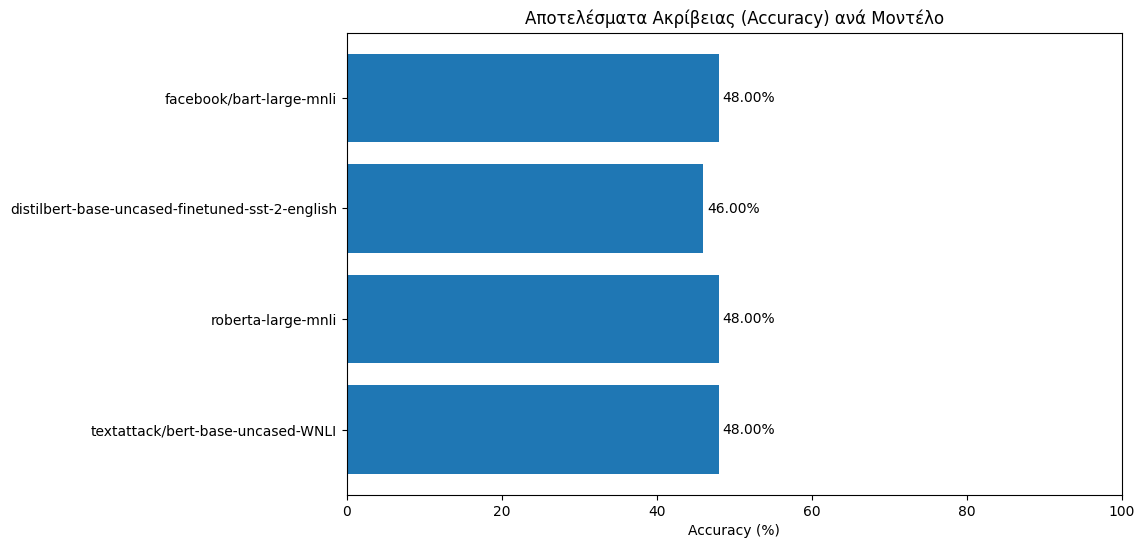

In [1]:
import matplotlib.pyplot as plt

# Δεδομένα
models = [
    "textattack/bert-base-uncased-WNLI",
    "roberta-large-mnli",
    "distilbert-base-uncased-finetuned-sst-2-english",
    "facebook/bart-large-mnli"
]

accuracies = [48.00, 48.00, 46.00, 48.00]

# Δημιουργία barplot
plt.figure(figsize=(10, 6))
bars = plt.barh(models, accuracies)

# Προσθήκη τιμών πάνω στα bars
for bar, acc in zip(bars, accuracies):
    plt.text(acc + 0.5, bar.get_y() + bar.get_height()/2,
             f"{acc:.2f}%", va='center')

plt.xlabel("Accuracy (%)")
plt.title("Αποτελέσματα Ακρίβειας (Accuracy) ανά Μοντέλο")
plt.xlim(0, 100)
plt.show()
